In [1]:
import re
import subprocess
from Bio import SeqIO
from Bio.Seq import Seq

In [2]:
blin = 'genes.fasta'
subj = 'genomic.gbff'
newsubj = 'RKQQC_annotated_chr.fa'
failsubj = 'RKQQC_unknown_chr.fa'
blastout = 'RKQQC_blastn.out'

In [3]:
chrom_conv = {}

with open(subj, 'r') as f, open(newsubj, 'w') as fout, open(failsubj, 'w') as fail:
    for record in SeqIO.parse(f, 'genbank'):
        for feature in record.features:
            if 'chromosome' in feature.qualifiers:
                chrom_conv[record.id] = feature.qualifiers['chromosome'][0]
                fout.write(f'>{record.id} - Chromosome: {feature.qualifiers['chromosome'][0]} ({len(record.seq)} bp)\n')
                fout.write(str(record.seq) + '\n')
            elif 'chromosome' not in feature.qualifiers:
                fail.write(f'>{record.id} - Chromosome: Unknown\n')
                fail.write(str(record.seq) + '\n')

In [28]:
subprocess.run(['blastn', '-query', blin, '-subject', newsubj, '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', blastout])

CompletedProcess(args=['blastn', '-query', 'genes.fasta', '-subject', 'RKQQC_annotated_chr.fa', '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', 'RKQQC_blastn.out'], returncode=0)

Find the genes that brought back a good match from the BLAST search + create dictionary with location of each of the gene

In [9]:
gene_dict = {}

with open(blastout, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        gene, chromID, pident, bitscore, sstart, send, sseq = line
        if chromID in chrom_conv:
            chrom = chrom_conv[chromID]
            if (gene not in gene_dict) and (int(float(bitscore)) > 1000) and (float(pident) > 95):
                gene_dict[gene] = chrom, int(sstart), int(send)

Process the gene-selection output to get SNPs/b for each gene that passed the BLAST search

In [72]:
tree_out = 'sampled_cds_old.csv'

with open(tree_out, 'r') as f:
    for line in f:
        line = line.strip().split(',')
        gene,snp_pb = line[8], line[11]
        if (gene in gene_dict) and (snp_pb not in gene_dict[gene]):
            gene_dict[gene] = gene_dict[gene] + (float(snp_pb),)
        else:
            continue


ValueError: max() iterable argument is empty

Turn it into a matrix to plot the heatmap

In [37]:

snp_matrix = []
for gene, (chrom, start, end, snp) in gene_dict.items():
    if gene not in snp_matrix:
        snp_matrix.append([gene, snp])

print(snp_matrix)
print(min([x[1] for x in snp_matrix]))

[['PGTG_19919', '0.15835777126099698'], ['PGTG_19587', '0.22685185185185217'], ['PGTG_19160', '0.1331719128329297'], ['PGTG_18858', '0.14252873563218382'], ['PGTG_19012', '0.13601532567049812'], ['PGTG_19043', '0.13452914798206297'], ['PGTG_22627', '0.15895953757225428'], ['PGTG_22597', '0.16367713004484333'], ['PGTG_18583', '0.2016806722689071'], ['PGTG_18625', '0.16628175519630467'], ['PGTG_18631', '0.19940476190476172'], ['PGTG_22615', '0.14058355437665793'], ['PGTG_18310', '0.14444444444444443'], ['PGTG_18464', '0.1406926406926407'], ['PGTG_17963', '0.13836477987421378'], ['PGTG_17781', '0.13157894736842105'], ['PGTG_17351', '0.17260273972602727'], ['PGTG_22457', '0.24999999999999964'], ['PGTG_17020', '0.152542372881356'], ['PGTG_16374', '0.1466083150984681'], ['PGTG_17060', '0.13861386138613868'], ['PGTG_17064', '0.1871345029239766'], ['PGTG_17070', '0.17391304347826095'], ['PGTG_17077', '0.13276231263383304'], ['PGTG_17079', '0.1543026706231454'], ['PGTG_22393', '0.26934097421203

Make circos plot

In [13]:
# %pip install pycirclize
from pycirclize import Circos
from pycirclize.parser import Genbank
gbk = Genbank(subj)

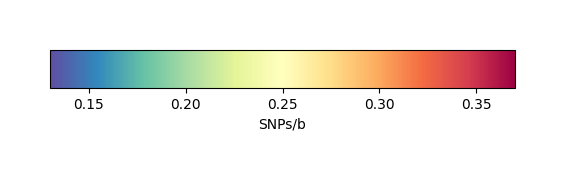

In [112]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar

spectral = plt.get_cmap('Spectral', 256)
spectral = spectral.reversed()
norm = mcolors.Normalize(vmin=min([x[1] for x in snp_matrix]), vmax=max([x[1] for x in snp_matrix]))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = spectral
cb = mcolorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')

cb.set_label('SNPs/b')

plt.savefig('RKQQC_legend_heatmap.pdf')

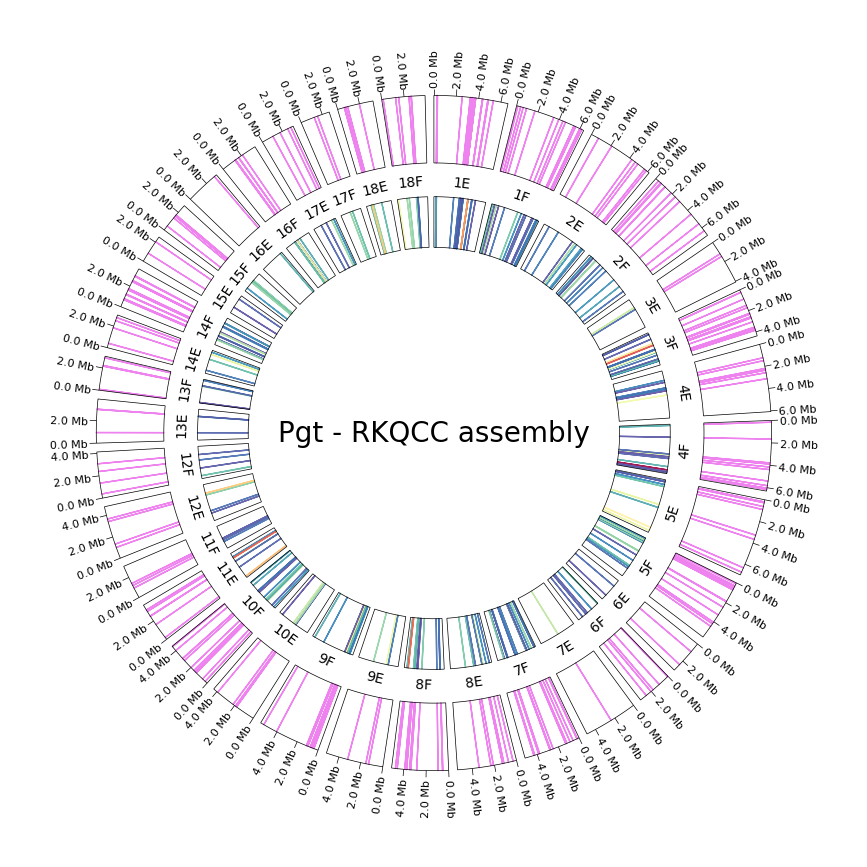

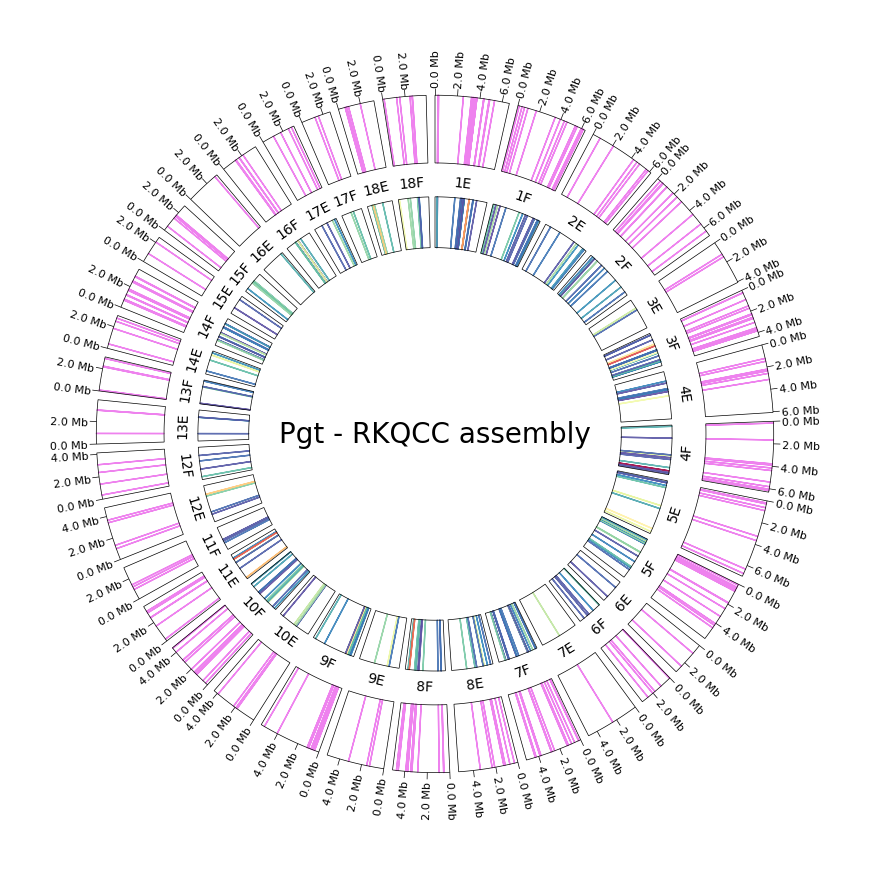

In [115]:

chr_sectors = {feature.qualifiers['chromosome'][0]: len(record.seq) for record in gbk.records for feature in record.features if 'chromosome' in feature.qualifiers}
circos = Circos(sectors=chr_sectors, space=1.5)
circos.text(f'Pgt - RKQCC assembly', size=20)

for sector in circos.sectors:
    sector.text(f'{sector.name}', r=72.5, rotation=90, size=10, ha='center', va='center', color='black')
    geneloc_track = sector.add_track((80, 100), r_pad_ratio=0)
    geneloc_track.xticks_by_interval(interval=2000000, label_orientation='vertical', label_formatter=lambda v: f"{v / 1000000:.1f} Mb")
    geneloc_track.axis()
    heatmap_track = sector.add_track((55, 70), r_pad_ratio=0)
    heatmap_track.axis()
    for gene, (chrom, sstart, send, snp_pb) in gene_dict.items():
        color = spectral(norm(float(snp_pb)))
        if chrom == sector.name:
            geneloc_track.rect(sstart, send, color='violet', lw=1)
            heatmap_track.rect(sstart, send, color=color, lw=1, alpha=0.9)

circos.plotfig()

In [113]:
circos.savefig('RKQQC_circos_heatmap.pdf')